In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
import tensorflow as tf
from sklearn.model_selection import train_test_split
import cv2
from tqdm.notebook import tqdm

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten
from tensorflow.keras.optimizers import SGD

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
#        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
train_df = pd.read_csv('/kaggle/input/cs-uni-fundamentos-de-procesamiento-de-imgenes/train.csv')
train_df.head()

,fileName,pneumonia
0,ae5f764f-8cc0-4754-8ab1-44e4a3ed017d.jpeg,1
1,39823342-15b0-4a07-909a-1ee04f8735d4.jpeg,1
2,ce88c057-803c-41ce-b880-d4924587c368.jpeg,1
3,c4097f64-0ace-4848-bfaf-45d7294e6d98.jpeg,1
4,baca3585-a4b8-4cab-95f2-71787e36edf1.jpeg,1


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3074 entries, 0 to 3073
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   fileName   3074 non-null   object
 1   pneumonia  3074 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 48.2+ KB


In [4]:
ruta = '/kaggle/input/cs-uni-fundamentos-de-procesamiento-de-imgenes/images/images/'

def cargar(ruta, lista):
    lista = ruta + lista.astype(str)
    lista_files = lista.to_numpy()
    #lista_labels = np.array(['pneumonia']*len(lista_files))

    lista_images = []
    for file_image in tqdm(lista_files):
        image = cv2.imread(file_image)
        image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        image = cv2.resize(image, dsize=(200,200))
        lista_images.append(image)

    lista_images = np.array(lista_images)

    #return lista_images, lista_labels
    return lista_images

x = train_df['fileName']
x_ima = cargar(ruta, x)

  0%|          | 0/3074 [00:00<?, ?it/s]

Imagenes


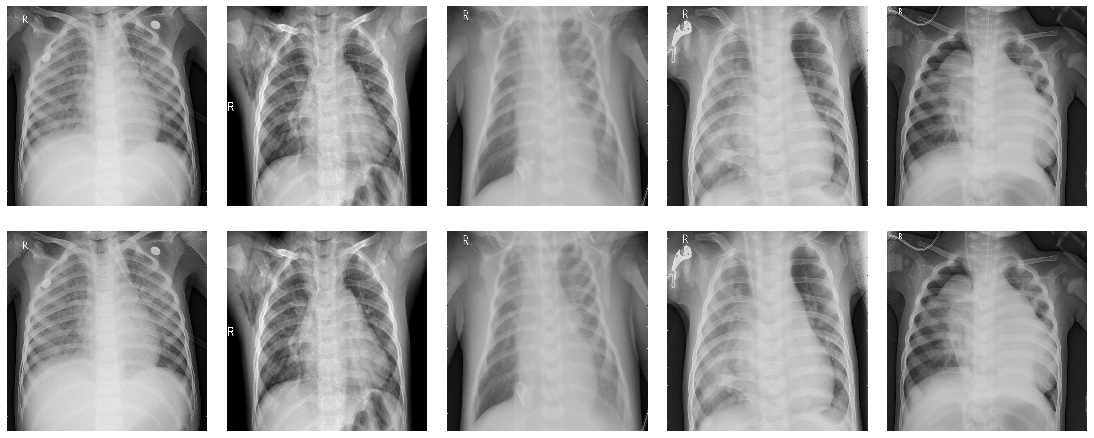

In [5]:
#plt.imshow(x_ima[0], cmap='gray')

print("Imagenes")

fig, axis = plt.subplots(2, 5, figsize=(15, 15))

for i in range(2):
    for j in range(5):
        axis[i, j].imshow(x_ima[j], cmap="gray")
        axis[i, j].axis("off")
plt.subplots_adjust(wspace=0.1, hspace=-0.7, left=0, right=1, bottom=0.1, top=1)
plt.show()


In [6]:
y = train_df['pneumonia']
y[0]


1

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x_ima, y, test_size=0.2, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2459, 200, 200), (615, 200, 200), (2459,), (615,))

In [8]:
mean = x_train.mean()
std = x_train.std()
x_train = (x_train - mean) / std
x_test = (x_test - mean) / std
print(f'Train -> x: {x_train.shape}')
print(f'         y: {y_train.shape}')
print(f'Test -> x: {x_test.shape}')
print(f'        y: {y_test.shape}')

Train -> x: (2459, 200, 200)
         y: (2459,)
Test -> x: (615, 200, 200)
        y: (615,)


In [9]:
# Reshaping X data
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
x_train.shape, x_test.shape

((2459, 200, 200, 1), (615, 200, 200, 1))

In [10]:
# Modelo
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
import numpy as np
from keras import Input, Model
from keras.layers import SimpleRNN, Dense

K.clear_session()

lr = 0.01
bs = 32
nb = math.ceil(len(x_train)/bs) # Nro de batches
l2_w = 1e-4

model = Sequential([
    Conv2D(32, 3, activation='relu', padding='same', input_shape=(200,200,1), kernel_regularizer=l2(l2_w)), # 16 filtros de 3x3
    MaxPool2D(),
    Dropout(0.3),
    Conv2D(64, 3, activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.3),
    Conv2D(128, 3, activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.3),
    Conv2D(32, 3, activation='relu', padding='same'),
    MaxPool2D(),
    Dropout(0.3),
    Flatten(),
    Dense(100, activation='relu', kernel_initializer='he_normal', use_bias=False),
    BatchNormalization(),
    Dropout(0.3),
    Dense(60, activation='relu', use_bias=False),
    BatchNormalization(),
    Dropout(0.3),
    Dense(40, activation='relu', use_bias=False),
    BatchNormalization(),
    Dropout(0.3),
    Dense(2, activation='softmax', kernel_regularizer=l2(l2_w))
])

model.compile(Adam(lr), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 32)      320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 100, 100, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 50, 50, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 50, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 50, 50, 128)       7

In [11]:
# Trainning
log = model.fit(x_train, y_train, batch_size=nb, epochs=50, validation_data=(x_test, y_test))

Epoch 1/50
32/32 [==============================] - 11s 115ms/step - loss: 0.6725 - accuracy: 0.6813 - val_loss: 0.8028 - val_accuracy: 0.7902
Epoch 2/50
32/32 [==============================] - 2s 66ms/step - loss: 0.3105 - accuracy: 0.8728 - val_loss: 0.3394 - val_accuracy: 0.8699
Epoch 3/50
32/32 [==============================] - 2s 71ms/step - loss: 0.2533 - accuracy: 0.8918 - val_loss: 0.2478 - val_accuracy: 0.8927
Epoch 4/50
32/32 [==============================] - 2s 66ms/step - loss: 0.2644 - accuracy: 0.8902 - val_loss: 0.2992 - val_accuracy: 0.8829
Epoch 5/50
32/32 [==============================] - 2s 65ms/step - loss: 0.2375 - accuracy: 0.9052 - val_loss: 0.9608 - val_accuracy: 0.7593
Epoch 6/50
32/32 [==============================] - 2s 66ms/step - loss: 0.2013 - accuracy: 0.9284 - val_loss: 0.8943 - val_accuracy: 0.7268
Epoch 7/50
32/32 [==============================] - 2s 65ms/step - loss: 0.1938 - accuracy: 0.9272 - val_loss: 0.7326 - val_accuracy: 0.7512
Epoch 8/50


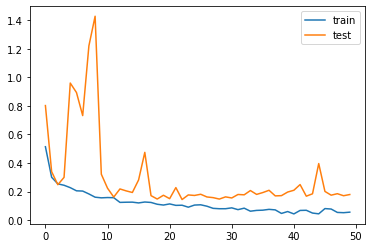

In [12]:
plt.plot(log.history['loss'], label='train')
plt.plot(log.history['val_loss'], label='test')
plt.legend();

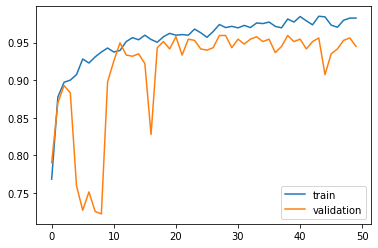

In [13]:
plt.plot(log.history['accuracy'], label='train')
plt.plot(log.history['val_accuracy'], label='validation')
plt.legend()

In [14]:
val_loss, val_acc = model.evaluate(x_test, y_test)
print(f'Loss = {val_loss:.2f}\nAccuracy = {val_acc:.2f}')

20/20 [==============================] - 0s 12ms/step - loss: 0.1789 - accuracy: 0.9447
Loss = 0.18
Accuracy = 0.94


In [15]:
!ls /kaggle/input/cs-uni-fundamentos-de-procesamiento-de-imgenes/

 images  'sample_submission (4).csv'   train.csv


In [16]:
data = pd.read_csv('/kaggle/input/cs-uni-fundamentos-de-procesamiento-de-imgenes/sample_submission (4).csv')

data.head()

,fileName,pneumonia
0,b8f6db1b-8bc3-494f-84f0-f7ed6435e6d2.jpeg,1.0
1,fb662f9a-b0c4-4ea6-b278-88161f17f4ad.jpeg,1.0
2,97b254d1-c1a3-4554-9140-ec0203e355cf.jpeg,1.0
3,01ae9376-8052-4cce-85bf-5019ebadaf32.jpeg,1.0
4,c16175b7-218f-4e72-8e29-8c96c0f0df69.jpeg,1.0


In [17]:
print('Datos = ',len(data))

Datos =  1025


In [18]:
y_pre = data['pneumonia'][0]
y_pre

1.0

  0%|          | 0/1025 [00:00<?, ?it/s]

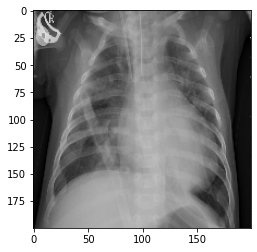

In [19]:
x_pre = data['fileName']
x_pre_ima = cargar(ruta, x_pre)
plt.imshow(x_pre_ima[0], cmap='gray')

In [20]:
mean = x_pre_ima.mean()
std = x_pre_ima.std()
x_pre_ima = (x_pre_ima - mean) / std

# Reshaping X data
x_pre_ima = x_pre_ima.reshape(x_pre_ima.shape[0], x_pre_ima.shape[1], x_pre_ima.shape[2], 1)

x_pre_ima.shape

(1025, 200, 200, 1)

In [21]:
predecir = model.predict(x_pre_ima, verbose = 1)
print(predecir[0])

33/33 [==============================] - 0s 10ms/step
[1.3244375e-04 9.9986756e-01]
